# Importing necessary libraries

In [7]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

## Loading the data

In [8]:
train_dir = "../dataset/train"
test_dir = "../dataset/test"
val_dir = "../dataset/val"

## Basic Data information.

In [9]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("../dataset/train/PNEUMONIA")
pneumonia_dir = "../dataset/train/PNEUMONIA"

Train set:
------------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8


In [10]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

 Creating dataframe for counting classes.

In [11]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

Labels are: `0  NORMAL || 1  PNEUMONIA`

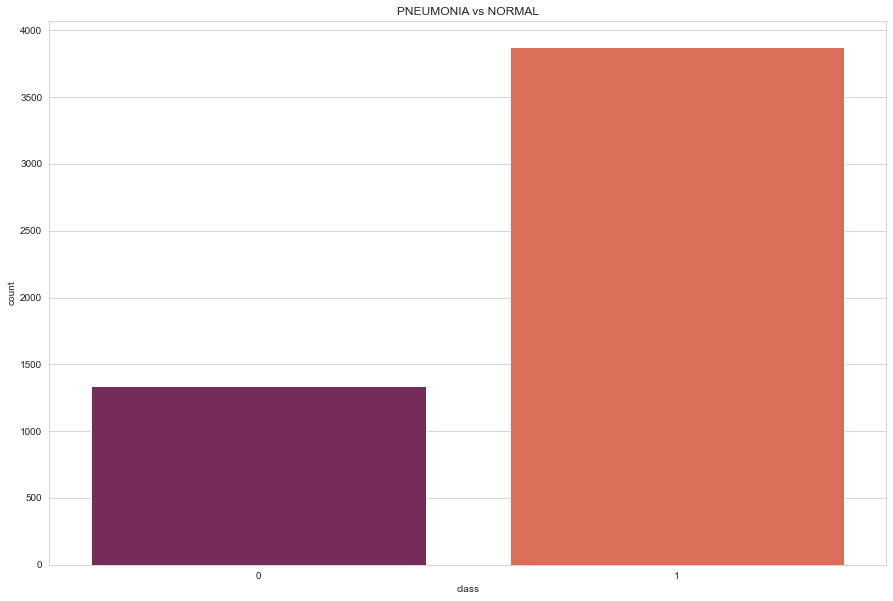

In [12]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

### There are more images of PNEUMONIA affected Xrays than NORMAL.

## Data Augmentation
 Using `ImageDataGenerator`, to augment our images so as to create a larger dataset for our model to train on..

In [13]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=False,
        vertical_flip=False,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=10,
        fill_mode = 'nearest'
)

val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [14]:

train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
img, label = next(train)

# Defining the model
- Using pre-trainied VGG19 model.
,Freezing all the layers of model of train.
,Using Adam as optimizer and binary_crossentropy as loss function.
,Using callbacks for avoiding overfitting case.
,Using ResNet pre-trained keras model
,Finding the best one among the and performing Fine Tune on it.
,Model evaluations.

In [16]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.AUC(name='AUC')]
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=METRICS)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [18]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/20
20/20 [==============================] - 77s 4s/step - loss: 0.5549 - accuracy: 0.7312 - val_loss: 0.7408 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 75s 4s/step - loss: 0.4851 - accuracy: 0.7516 - val_loss: 0.5915 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 76s 4s/step - loss: 0.4707 - accuracy: 0.7656 - val_loss: 0.5281 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 74s 4s/step - loss: 0.4564 - accuracy: 0.7891 - val_loss: 0.5169 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/20
20/20 [==============================] - 73s 4s/step - loss: 0.4195 - accuracy: 0.7969 - val_loss: 0.6372 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/20
20/20 [==============================] - 78s 4s/step - loss: 0.4149 - accuracy: 0.8141 - val_loss: 0.5320 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/20
20/20 [==============================] - 68s 3s/step - loss: 0.3819 - a

# Evaluating the VGG19

In [19]:
# Evaluating the model on train and test
score_train = model.evaluate(train)

print("Train Loss: ", score_train[0])
print("Train Accuracy: ", score_train[1])

# Test data
score_test = model.evaluate(test)

print("Test Loss: ", score_test[0])
print("Test Accuracy: ", score_test[1])

163/163 [==============================] - 626s 4s/step - loss: 0.2905 - accuracy: 0.8829
Train Loss:  0.2904667258262634
Train Accuracy:  0.8828604221343994


Text(0.5, 1.0, 'Accuracy Evolution')

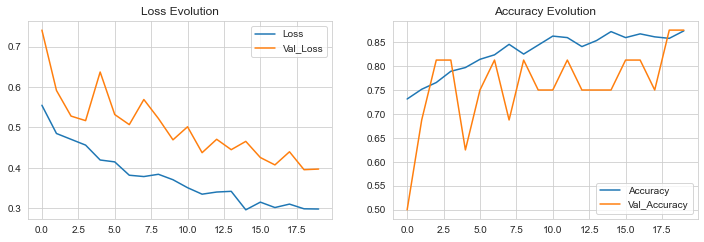

In [21]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# ResNet50V2

In [22]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=METRICS)

In [23]:
history = model2.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/20
20/20 [==============================] - 42s 2s/step - loss: 0.5490 - accuracy: 0.7828 - val_loss: 0.3206 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 38s 2s/step - loss: 0.2361 - accuracy: 0.8859 - val_loss: 0.1659 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 35s 2s/step - loss: 0.2482 - accuracy: 0.9000 - val_loss: 0.2670 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 33s 2s/step - loss: 0.1831 - accuracy: 0.9328 - val_loss: 0.1528 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/20
20/20 [==============================] - 32s 2s/step - loss: 0.2177 - accuracy: 0.9203 - val_loss: 0.1920 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/20
20/20 [==============================] - 33s 2s/step - loss: 0.1803 - accuracy: 0.9281 - val_loss: 0.1676 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/20
20/20 [==============================] - 33s 2s/step - loss: 0.1847 - a

In [24]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 254s 2s/step - loss: 0.1587 - accuracy: 0.9360
Train Loss:  0.15869371592998505
Train Accuracy:  0.9359662532806396
312/312 [==============================] - 49s 156ms/step - loss: 0.2433 - accuracy: 0.8958

Test loss:  0.2432611733675003
Test Accuracy:  0.8958333134651184


Text(0.5, 1.0, 'Accuracy Evolution')

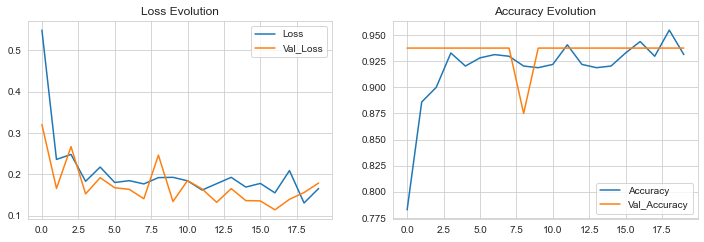

In [25]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# Observation:
,`ResNet50V2` perofmed well and looks better on the graph than `VGG19`. 

# Fine Tuning
,One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [26]:
resnet_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [28]:
# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=METRICS)

In [29]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [30]:
len(model2.trainable_variables)

86

In [31]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model2.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/40
20/20 [==============================] - 83s 4s/step - loss: 0.3406 - accuracy: 0.8906 - val_loss: 1.1499 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/40
20/20 [==============================] - 84s 4s/step - loss: 0.2552 - accuracy: 0.9109 - val_loss: 200.5869 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
20/20 [==============================] - 77s 4s/step - loss: 0.2081 - accuracy: 0.9203 - val_loss: 171.9136 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
20/20 [==============================] - 80s 4s/step - loss: 0.1864 - accuracy: 0.9312 - val_loss: 47.8735 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/40
20/20 [==============================] - 78s 4s/step - loss: 0.1571 - accuracy: 0.9422 - val_loss: 7.3403 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/40
20/20 [==============================] - 78s 4s/step - loss: 0.1887 - accuracy: 0.9266 - val_loss: 0.9921 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/40
20/20 [==============================] - 77s 4s/step - loss: 0.144

# Evaluating the Fine Tune model

In [32]:
# Evaluating the model on train and test
score2_train = model2.evaluate(train)

print("Train Loss: ", score2_train[0])
print("Train Accuracy: ", score2_train[1])

score2_test = model2.evaluate(test)
print("\nTest loss: ", score2_test[0])
print("Test Accuracy: ", score2_test[1])

163/163 [==============================] - 252s 2s/step - loss: 0.2451 - accuracy: 0.9408
Train Loss:  0.2451159507036209
Train Accuracy:  0.9407591819763184
312/312 [==============================] - 43s 139ms/step - loss: 0.4822 - accuracy: 0.9103

Test loss:  0.4821838438510895
Test Accuracy:  0.9102563858032227


Text(0.5, 1.0, 'Accuracy Evolution')

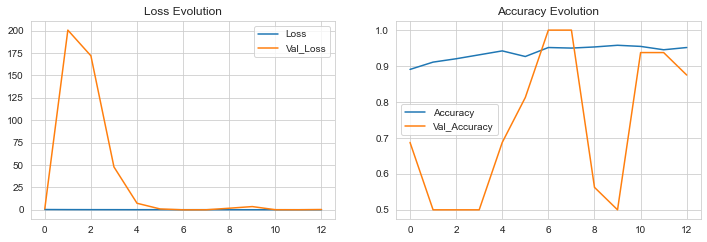

In [33]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

## Compare

In [2]:
print("Train Loss: ", 0.13077424466609955)
print("Train Accuracy: ", 0.9486196041107178)

# Test data
print("\nTest Loss: ", 0.19524818658828735)
print("Test Accuracy: ", 0.9278846383094788)

Train Loss:  0.13077424466609955
Train Accuracy:  0.9486196041107178

Test Loss:  0.19524818658828735
Test Accuracy:  0.9278846383094788


In [5]:
import pandas as pd

In [9]:
score_vg = {"loss": 0.3542, "accuracy": 0.8462 , "precision": 0.9016 , "recall": 0.8462 , "fn": 60 , "fp": 36  , "tn": 198  , "tp": 330  , "AUC": 0.9285}
score_resnet = {"loss": 0.1952 , "accuracy": 0.9279 , "precision": 0.9367 , "recall": 0.9487 , "fn": 20  , "fp": 25  , "tn": 209  , "tp": 370  , "AUC": 0.9750}
scores = {"VGG19 Metrics": score_vg, "ResNet50v2 Metrics": score_resnet}
score_final = {"loss": 0.1468 ,"accuracy": 0.9439 ,"precision": 0.9494 ,"recall": 0.9615 ,"fn": 15.0000 ,"fp": 20.0000 ,"tn": 214.0000 ,"tp": 375.0000 ,"AUC": 0.9871}
score_fin = {"ResNet50v2 Fine Tuned": score_final}
scores

{'VGG19 Metrics': {'loss': 0.3542,
  'accuracy': 0.8462,
  'precision': 0.9016,
  'recall': 0.8462,
  'fn': 60,
  'fp': 36,
  'tn': 198,
  'tp': 330,
  'AUC': 0.9285},
 'ResNet50v2 Metrics': {'loss': 0.1952,
  'accuracy': 0.9279,
  'precision': 0.9367,
  'recall': 0.9487,
  'fn': 20,
  'fp': 25,
  'tn': 209,
  'tp': 370,
  'AUC': 0.975}}

In [10]:
df = pd.DataFrame(data=score_fin)
df

,ResNet50v2 Fine Tuned
AUC,0.9871
accuracy,0.9439
fn,15.0000
fp,20.0000
loss,0.1468
precision,0.9494
recall,0.9615
tn,214.0000
tp,375.0000
